In [1]:
# Standard packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import os

from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFECV
from sklearn.decomposition import PCA

# Model Evaluation
from sklearn import datasets, metrics, svm
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
data = pd.read_csv("data.csv", sep=";")
df = data.copy(deep=True)

<a id='EDA'></a>

## EDA

In [27]:
print(df.info())
print("MISSING VALUES: ", df.isnull().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      316 non-null    object
 1   sex         316 non-null    object
 2   age         316 non-null    int64 
 3   address     316 non-null    object
 4   famsize     316 non-null    object
 5   Pstatus     316 non-null    object
 6   Medu        316 non-null    int64 
 7   Fedu        316 non-null    int64 
 8   Mjob        316 non-null    object
 9   Fjob        316 non-null    object
 10  reason      316 non-null    object
 11  guardian    316 non-null    object
 12  traveltime  316 non-null    int64 
 13  studytime   316 non-null    int64 
 14  failures    316 non-null    int64 
 15  schoolsup   316 non-null    object
 16  famsup      316 non-null    object
 17  paid        316 non-null    object
 18  activities  316 non-null    object
 19  nursery     316 non-null    object
 20  higher    

In [4]:
print(df.describe().T)
print(75*"-")
display(df.head())

            count       mean       std   min   25%   50%   75%   max
age         316.0  16.693038  1.310791  15.0  16.0  17.0  18.0  22.0
Medu        316.0   2.768987  1.104301   0.0   2.0   3.0   4.0   4.0
Fedu        316.0   2.525316  1.070228   0.0   2.0   3.0   3.0   4.0
traveltime  316.0   1.436709  0.703132   1.0   1.0   1.0   2.0   4.0
studytime   316.0   2.088608  0.849872   1.0   2.0   2.0   2.0   4.0
failures    316.0   0.306962  0.724239   0.0   0.0   0.0   0.0   3.0
famrel      316.0   3.924051  0.908823   1.0   4.0   4.0   5.0   5.0
freetime    316.0   3.240506  0.968916   1.0   3.0   3.0   4.0   5.0
goout       316.0   3.151899  1.099363   1.0   2.0   3.0   4.0   5.0
Dalc        316.0   1.474684  0.899378   1.0   1.0   1.0   2.0   5.0
Walc        316.0   2.297468  1.311776   1.0   1.0   2.0   3.0   5.0
health      316.0   3.503165  1.404072   1.0   3.0   4.0   5.0   5.0
absences    316.0   5.693038  7.580096   0.0   0.0   4.0   8.0  56.0
G1          316.0  10.924051  3.19

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,16,U,LE3,T,4,3,teacher,services,...,5,4,3,1,2,1,2,16,15,15
1,GP,M,18,U,LE3,T,1,1,other,other,...,2,3,5,2,5,4,0,6,5,0
2,GP,M,17,R,LE3,A,4,4,teacher,other,...,3,3,3,2,3,4,2,10,11,12
3,GP,F,15,U,LE3,T,3,2,services,other,...,4,4,4,1,1,5,10,7,6,6
4,GP,M,16,U,GT3,T,2,3,other,other,...,5,3,3,1,1,3,0,13,14,14


In [5]:
# Separate categorical and numerical variables for investigation
numerical = [col for col in df.columns if df[col].dtype == "int64"]
categorical = [col for col in df.columns if df[col].dtype != "int64"]
print("Numerical features: ", len(numerical))
print("Categorical features: ", len(categorical))
display("Numerical features: ", df[numerical].head(2))
display("Categorical features: ", df[categorical].head(2))

Numerical features:  16
Categorical features:  17


'Numerical features: '

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,16,4,3,3,2,0,5,4,3,1,2,1,2,16,15,15
1,18,1,1,1,1,3,2,3,5,2,5,4,0,6,5,0


'Categorical features: '

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,GP,F,U,LE3,T,teacher,services,course,mother,no,yes,no,yes,yes,yes,yes,no
1,GP,M,U,LE3,T,other,other,course,mother,no,no,no,no,yes,no,yes,yes


In [6]:
df[categorical].nunique()

school        2
sex           2
address       2
famsize       2
Pstatus       2
Mjob          5
Fjob          5
reason        4
guardian      3
schoolsup     2
famsup        2
paid          2
activities    2
nursery       2
higher        2
internet      2
romantic      2
dtype: int64

In [7]:
#Split categorical features into binary and nominal for encoding flexibility
binary = [col for col in df.columns if df[col].nunique() ==2]
nominal = [col for col in df.columns if (df[col].dtype == 'object' and df[col].nunique() >2)]
#check length of 3 feature types matches total
print(len(numerical)+len(binary)+len(nominal))

33


In [8]:
# Investigate nominal categories Mjob + Fjob
display(df["Mjob"].value_counts())
display(df["Fjob"].value_counts())

Mjob
other       115
services     77
teacher      50
at_home      46
health       28
Name: count, dtype: int64

Fjob
other       175
services     86
teacher      24
at_home      16
health       15
Name: count, dtype: int64

In [9]:
# Investigate nominal categories reason + guardian
display(df["reason"].value_counts())
display(df["guardian"].value_counts())

reason
course        112
home           88
reputation     85
other          31
Name: count, dtype: int64

guardian
mother    221
father     67
other      28
Name: count, dtype: int64

In [28]:
# Look at the Target data 
df["G3"].value_counts()

G3
10    47
11    38
0     31
8     27
15    25
14    24
13    24
12    23
9     22
16    13
6     12
18     9
7      7
17     5
19     4
5      3
4      1
20     1
Name: count, dtype: int64

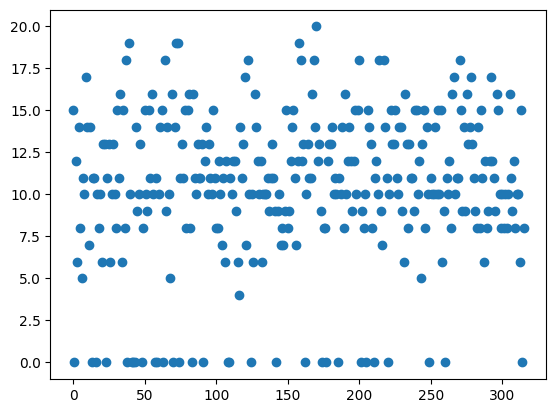

In [33]:
Grades = df["G3"].sort_values()
plt.scatter(Grades.index,Grades)

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'Medu'}>,
        <Axes: title={'center': 'Fedu'}>,
        <Axes: title={'center': 'traveltime'}>],
       [<Axes: title={'center': 'studytime'}>,
        <Axes: title={'center': 'failures'}>,
        <Axes: title={'center': 'famrel'}>,
        <Axes: title={'center': 'freetime'}>],
       [<Axes: title={'center': 'goout'}>,
        <Axes: title={'center': 'Dalc'}>,
        <Axes: title={'center': 'Walc'}>,
        <Axes: title={'center': 'health'}>],
       [<Axes: title={'center': 'absences'}>,
        <Axes: title={'center': 'G1'}>, <Axes: title={'center': 'G2'}>,
        <Axes: title={'center': 'G3'}>]], dtype=object)

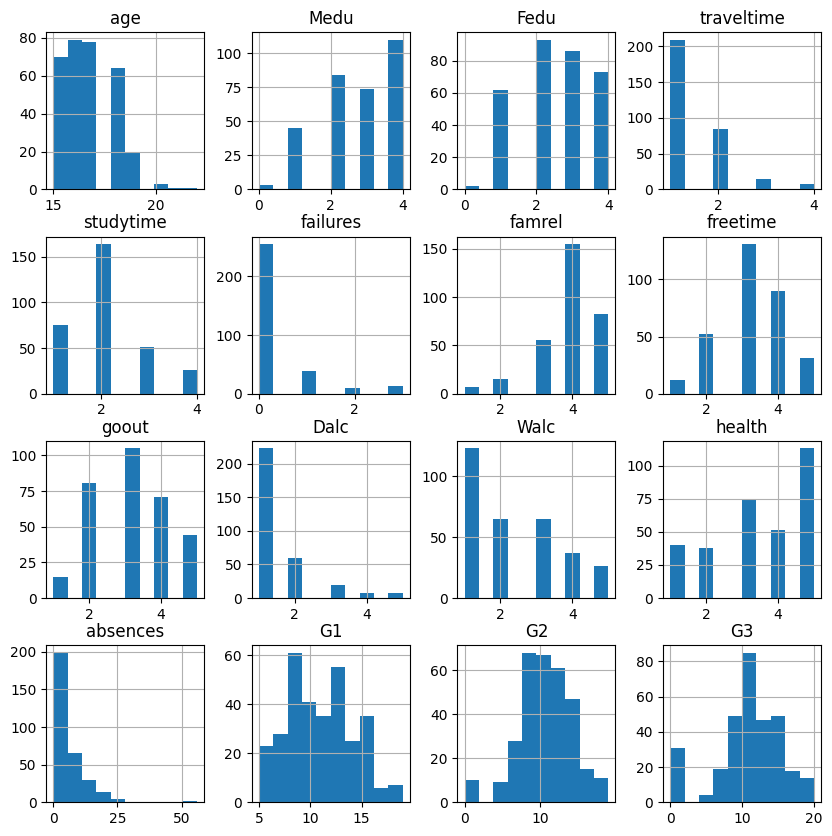

In [10]:
# Look at distribution of numerical data
df.hist(figsize=(10,10))

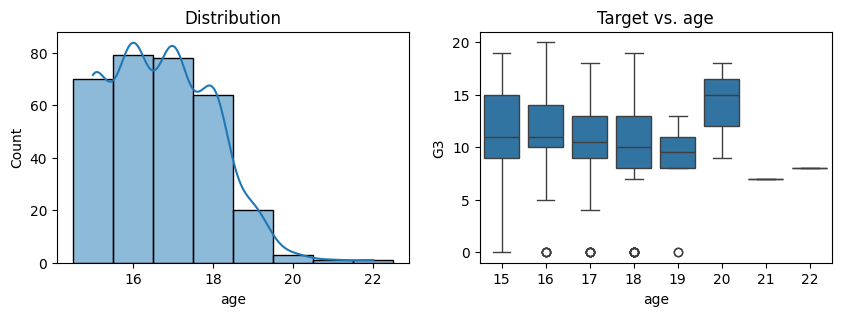

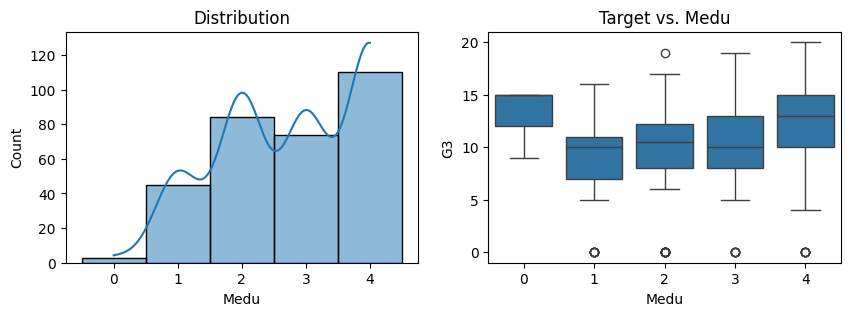

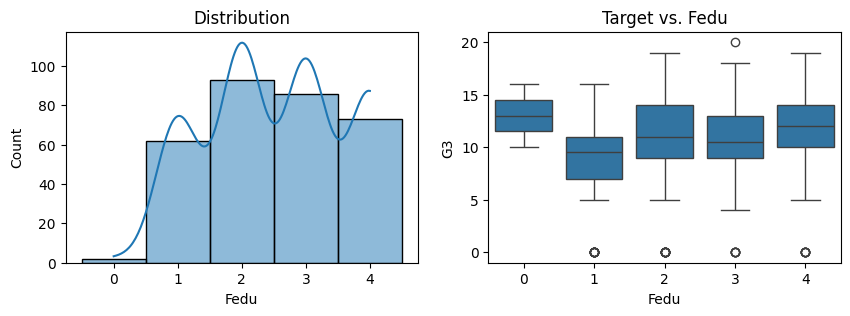

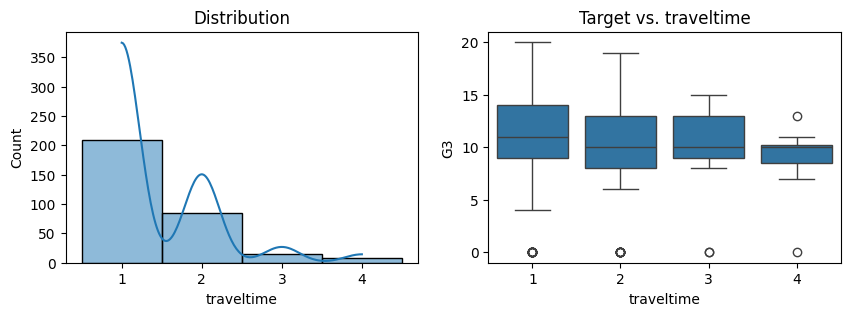

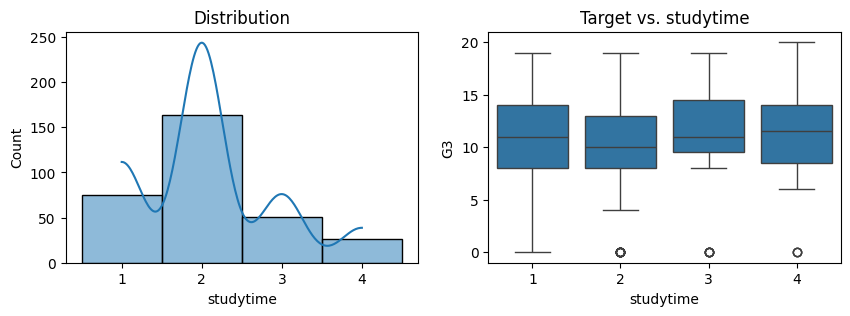

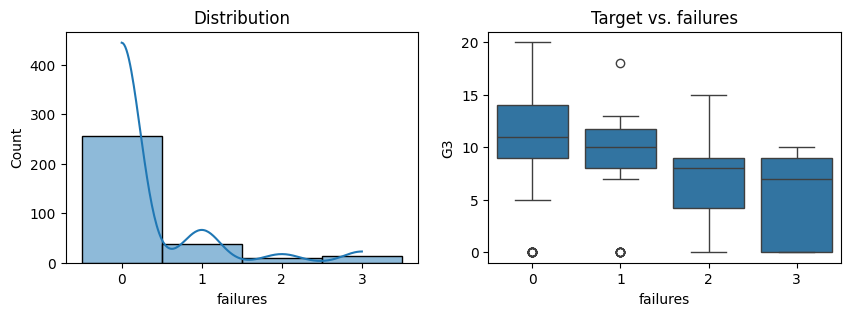

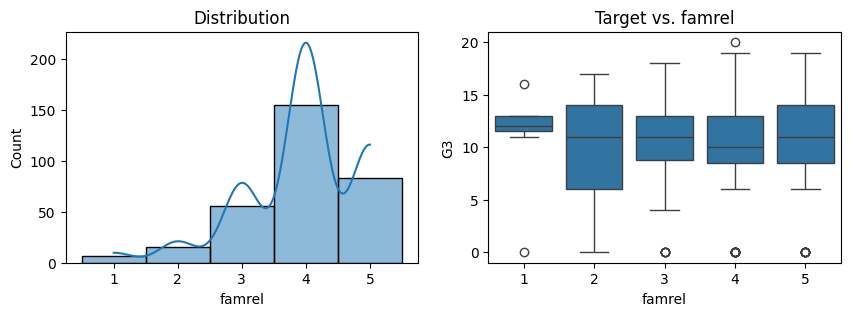

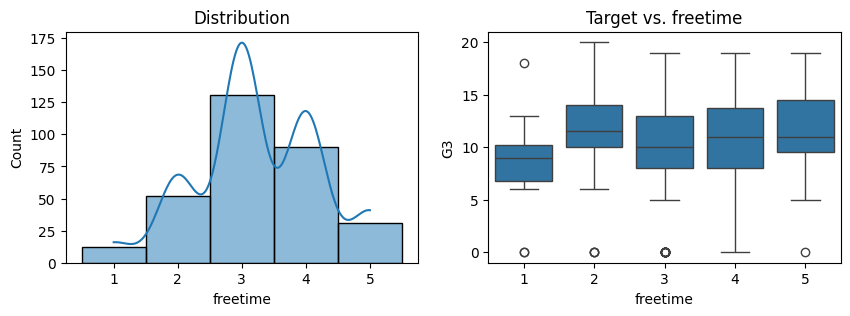

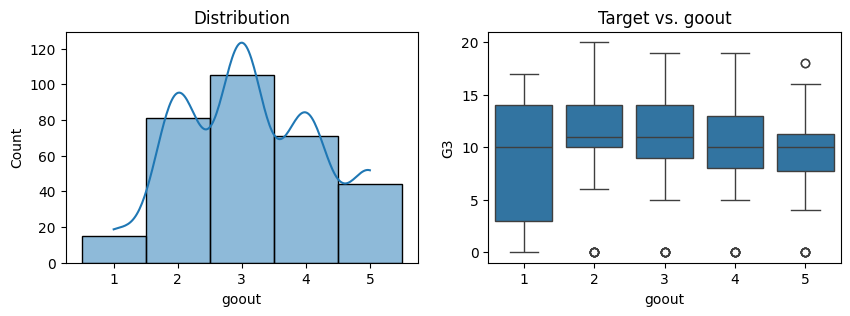

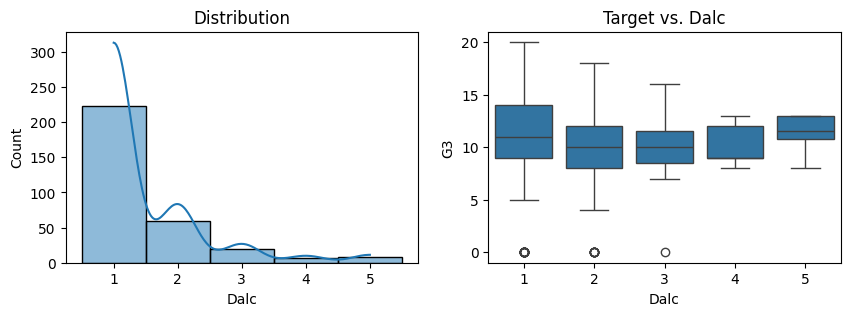

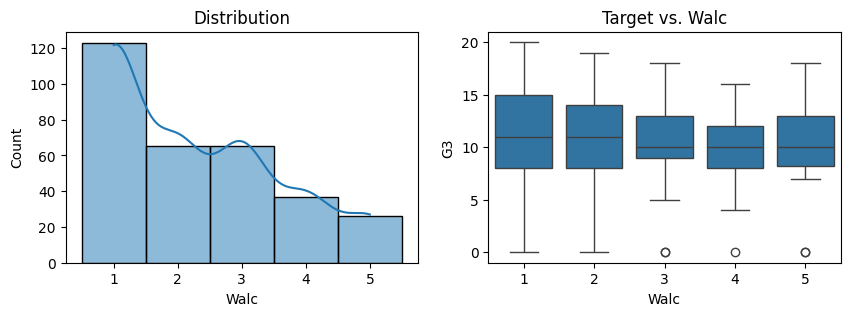

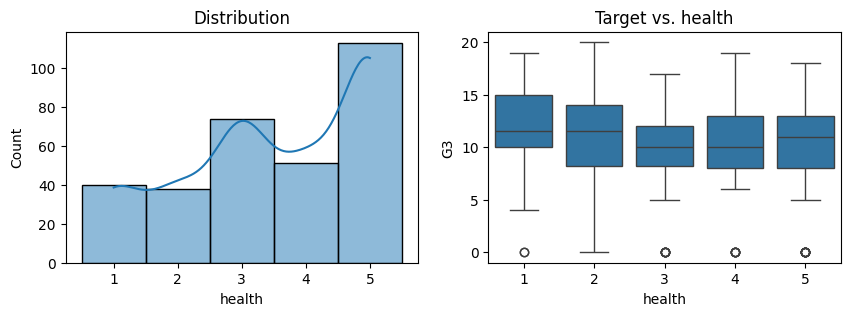

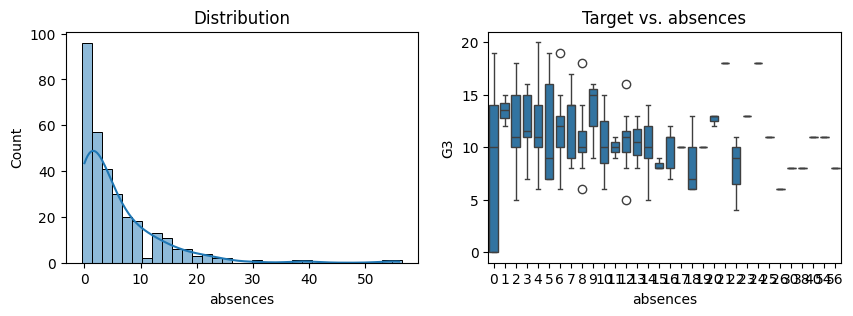

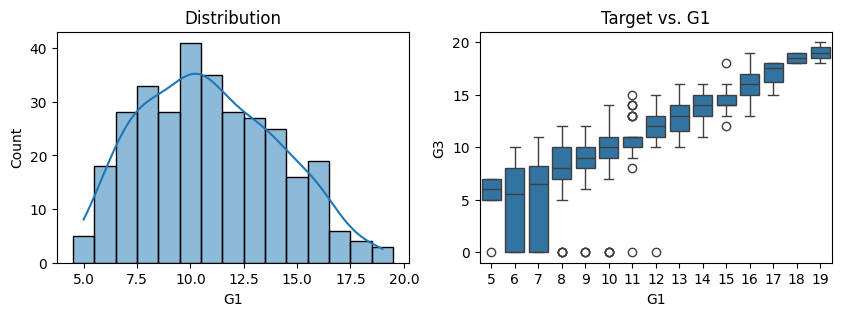

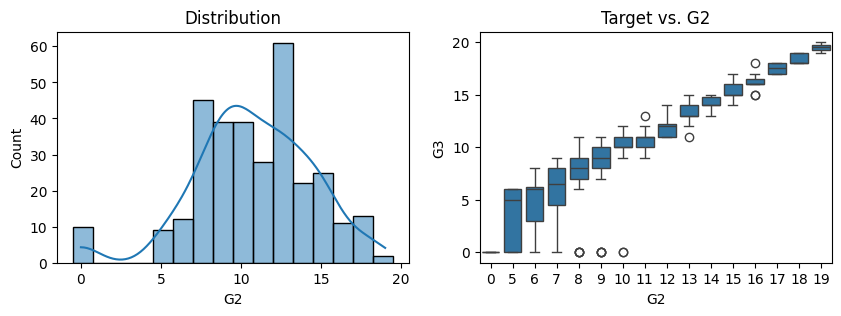

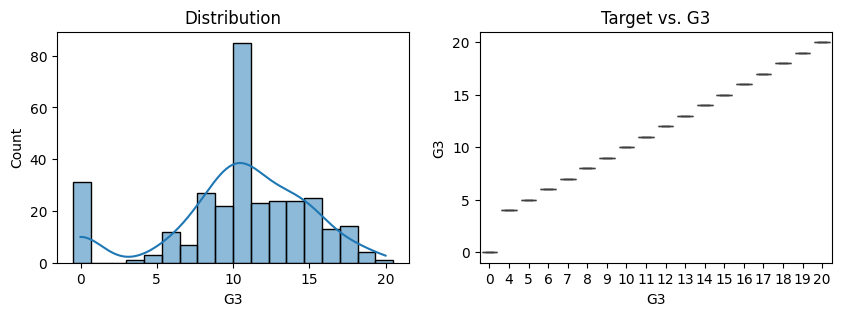

In [11]:
# Now again in more detail
for i in df[numerical].columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    bin_edges = np.linspace(df[i].min() - 0.5, df[i].max() + 0.5, df[i].nunique() + 1)
    ax1.title.set_text("Distribution")
    ax2.title.set_text(f"Target vs. {i}")
    sns.histplot(data=df, x=i, bins=bin_edges, kde=True, ax=ax1)
    sns.boxplot(data=df, x=i, y=df["G3"], ax=ax2)
    fig.tight_layout
    plt.show()

## Initial Feature Selection

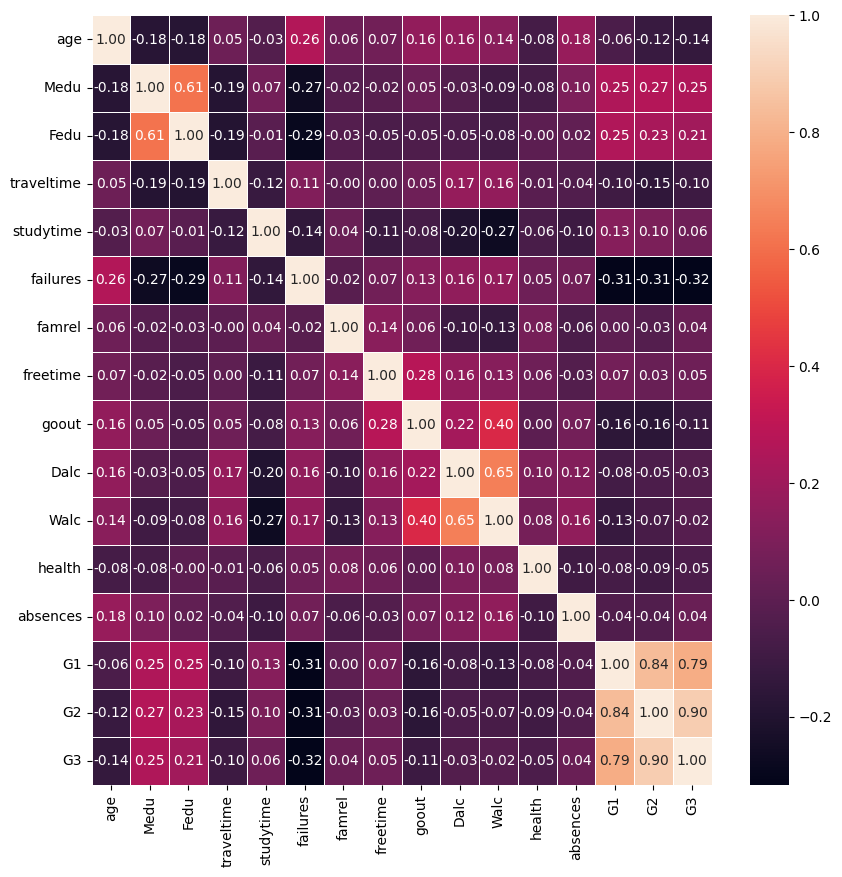

In [12]:
#check for correlation amongst numerical features
plt.figure(figsize=(10, 10))  # Adjust the figure size if needed
sns.heatmap(df[numerical].corr(), annot=True, fmt=".2f",linewidths=0.5)
plt.show()

### Create New Feature Sets, Strong Correlation and Weak Correlation

In [13]:
# Create 2 New Numerical Datasets: Weak correlation only and Strong correlation only
df_weakcorr = df.copy(deep=True)
df_weakcorr = df_weakcorr.drop(columns=["G1", "G2","failures","Dalc","Walc","goout","Fedu","Medu"])
df_strongcorr = df.copy(deep=True)
df_strongcorr = df_strongcorr[["G1", "G2","G3","failures","Dalc","Walc","goout","Fedu","Medu"]]
cwd = os.getcwd()
df_weakcorr.to_csv(cwd + "/df_weakcorr.csv")
df_strongcorr.to_csv(cwd + "/df_strongcorr.csv")

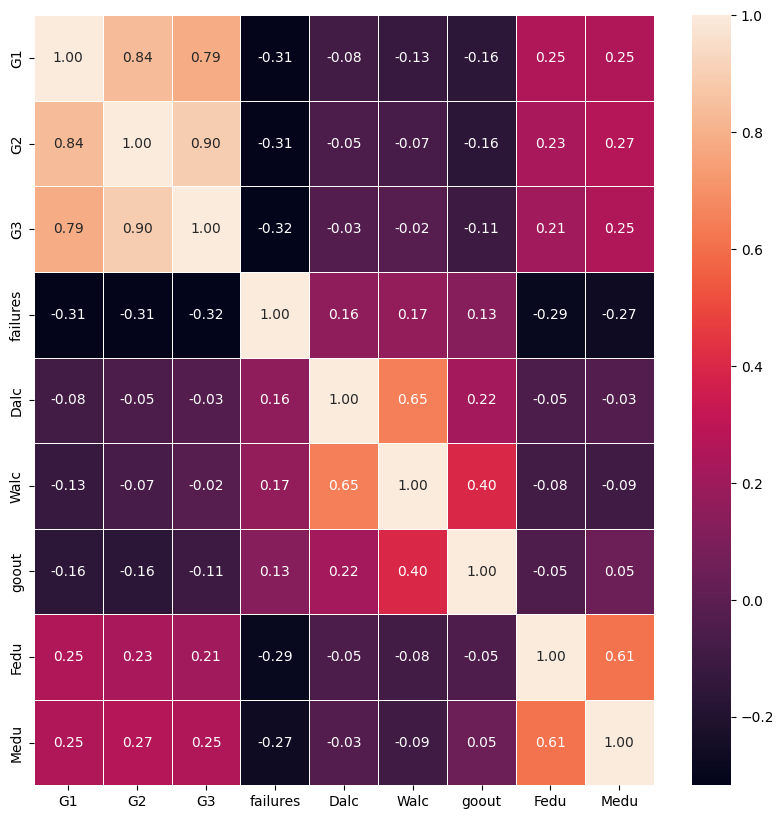

In [14]:
# Check correlation for Strong set
strongcorr_num = [col for col in df_strongcorr.columns if df_strongcorr[col].dtype != 'object']

plt.figure(figsize=(10, 10))  # Adjust the figure size if needed
sns.heatmap(df_strongcorr[strongcorr_num].corr(), annot=True, fmt=".2f", linewidths=0.5)
plt.show()

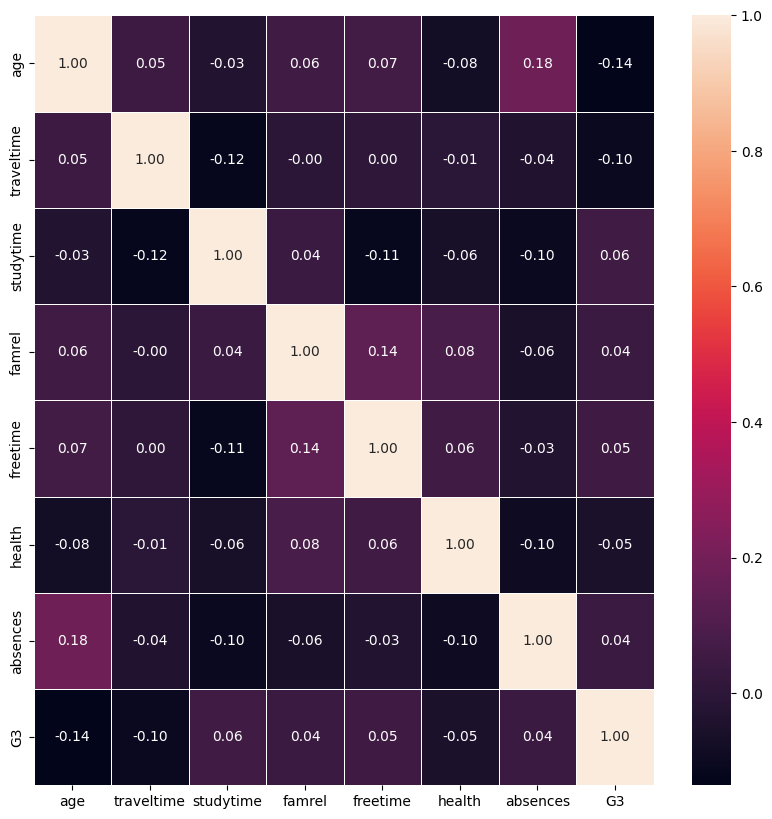

In [15]:
# Check correlation for weak set
weakcorr_num = [col for col in df_weakcorr.columns if df_weakcorr[col].dtype != 'object']

plt.figure(figsize=(10, 10))  # Adjust the figure size if needed
sns.heatmap(df_weakcorr[weakcorr_num].corr(), annot=True, fmt=".2f", linewidths=0.5)
plt.show()

## Let's try some feature engineering

#### I'll try combine some features with stronger correlation and replacing original features in df with those new features.

In [16]:
# Try adding some new features
df_combined = df.copy(deep=True)
df_combined['Education'] = df_combined["Medu"] + df_combined["Fedu"]
df_combined['Alcohol'] = df_combined["Dalc"] + df_combined["Walc"]
df_combined['Party'] = df_combined["Walc"] + df_combined["goout"]
df_combined['Grades'] = df_combined["G1"] + df_combined["G2"]
df_combined = df_combined[['Education','Alcohol','Party','Grades','G3']]
df_combined
df_combined.to_csv(cwd + "/df_combined.csv")

#### Now I'll make the df_bonus set 

In [17]:
# Create copy of df for use in bonus model
df_bonus = df.copy(deep=True)
df_bonus = df.drop(columns=["G1", "G2"])
df_bonus.to_csv(cwd + "/df_bonus.csv")

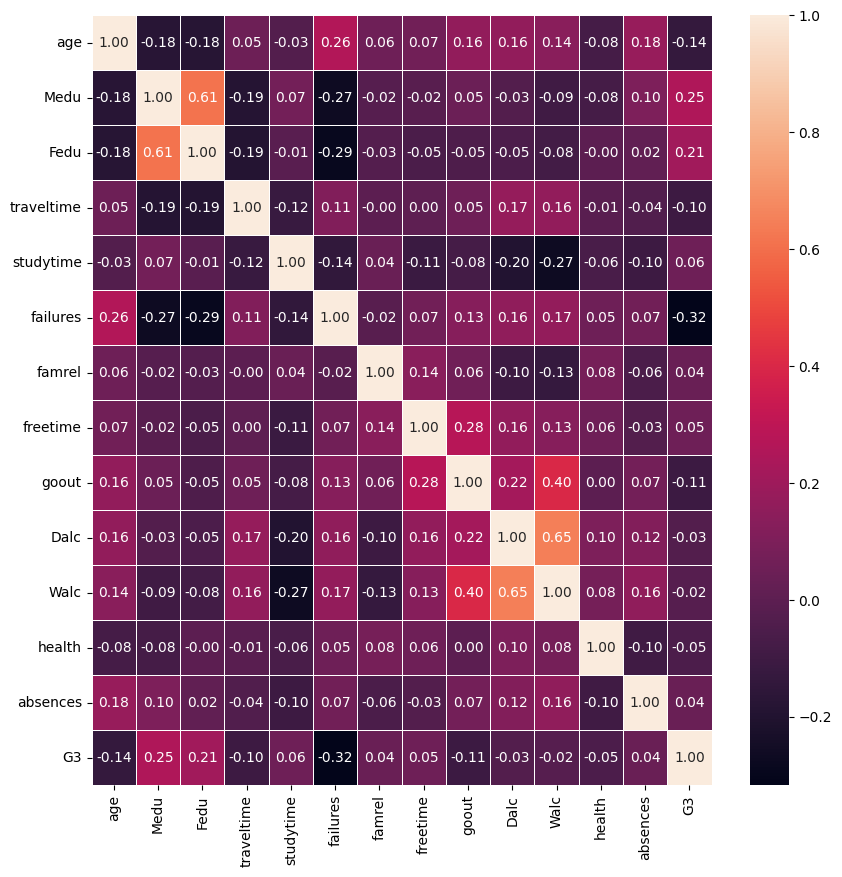

In [18]:
# Check correlation of bonus df
bonus_numerical = [col for col in numerical if col not in ("G1", "G2")]

plt.figure(figsize=(10, 10))  # Adjust the figure size if needed
sns.heatmap(df_bonus[bonus_numerical].corr(), annot=True, fmt=".2f", linewidths=0.5)
plt.show()

#### Take a look at Mutual Importance scores with categorical variables label-encoded

In [19]:
from sklearn.feature_selection import mutual_info_regression

X = df.copy()
y = X.pop("G3")

for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

discrete_features = X.dtypes == int

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
top5 = mi_scores[:6]
top10 = mi_scores[:11]
print("Top 5 by MI: ")
print(top5)
print('-'*50)
print("Top 10 by MI: ")
print(top10)

Top 5 by MI: 
G2          1.317633
G1          0.764156
absences    0.151962
failures    0.104907
Mjob        0.085706
romantic    0.064951
Name: MI Scores, dtype: float64
--------------------------------------------------
Top 10 by MI: 
G2           1.317633
G1           0.764156
absences     0.151962
failures     0.104907
Mjob         0.085706
romantic     0.064951
Dalc         0.062336
higher       0.041680
paid         0.041337
Medu         0.031871
schoolsup    0.028366
Name: MI Scores, dtype: float64


In [20]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(6,6))

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

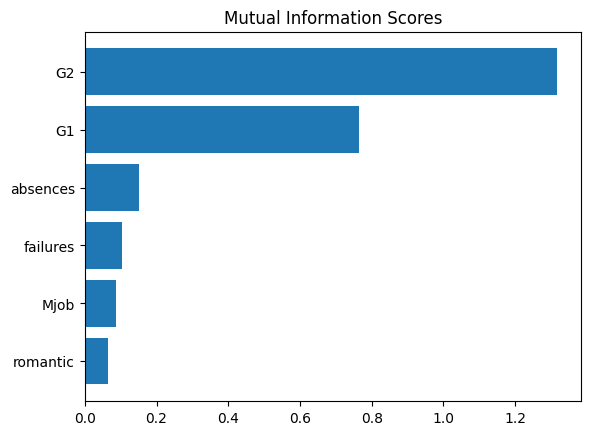

In [21]:
plot_mi_scores(top5)

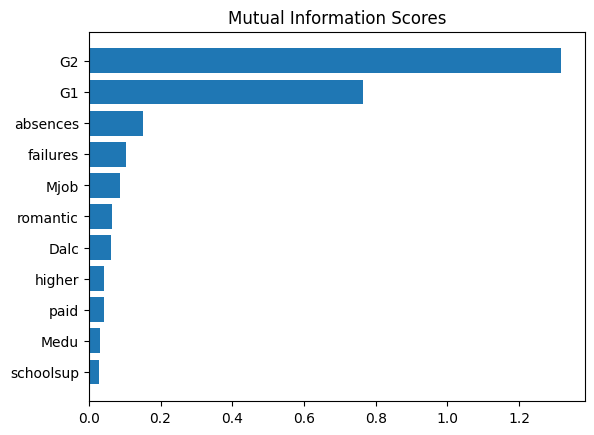

In [22]:
plot_mi_scores(top10)

#### We will make 2 sets based on MI score, best 5 features and best 10 features.

In [25]:
# Dataframe with only top 5 feature chosen by MI score
# Save to df_mi5.csv
five = list(top5.keys())
five.append('G3')
df_mi5 = df[five]
df_mi5['G3'] = df['G3']
display(df_mi5.head())
df_mi5.to_csv(cwd + "/df_mi5.csv")

/var/folders/jt/xt1b3v5j4171llx14wtwgmpc0000gn/T/ipykernel_49180/1845205929.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mi5['G3'] = df['G3']


,G2,G1,absences,failures,Mjob,romantic,G3
0,15,16,2,0,teacher,no,15
1,5,6,0,3,other,yes,0
2,11,10,2,0,teacher,no,12
3,6,7,10,0,services,no,6
4,14,13,0,0,other,no,14


In [26]:
# Dataframe with only top 5 feature chosen by MI score
# Save to df_mi10.csv
list(top10.keys())
df_mi10 = df[list(top10.keys())]
df_mi10['G3'] = df['G3']
display(df_mi10.head())
df_mi10.to_csv(cwd + "/df_mi10.csv")

/var/folders/jt/xt1b3v5j4171llx14wtwgmpc0000gn/T/ipykernel_49180/468058078.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mi10['G3'] = df['G3']


,G2,G1,absences,failures,Mjob,romantic,Dalc,higher,paid,Medu,schoolsup,G3
0,15,16,2,0,teacher,no,1,yes,no,4,no,15
1,5,6,0,3,other,yes,2,no,no,1,no,0
2,11,10,2,0,teacher,no,2,yes,yes,4,no,12
3,6,7,10,0,services,no,1,yes,yes,3,no,6
4,14,13,0,0,other,no,1,yes,no,2,no,14
